# Task 1: Investigating Inductive Biases in CNNs vs. ViTs
**Group Members:** Muhammad Abdullah Sohail, Muhammad Haseeb, Salaar Masood  
**Models:** ResNet-50 vs. ViT-S/16  
**Dataset:** CIFAR-10

This notebook contains a robust and reproducible workflow for Task 1. It is designed to:
1. Fine-tune the specified models and save the best checkpoints to persistent storage (``).
2. Create a suite of perturbed test datasets to probe for specific biases.
3. Evaluate models on all test sets, capturing both accuracy and prediction consistency.
4. Extract and visualize the feature representations using UMAP.
5. Aggregate all results into a clean, report-ready table.

### Setup and Imports

In [2]:
# --- 1. INSTALL LIBRARIES ---
# !pip install -q timm scikit-learn seaborn umap-learn
# --- 2. IMPORTS ---
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import copy
import os
from PIL import Image
from tqdm import tqdm  
import umap

# --- 3. CONFIGURATION ---
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the persistent working directory for saving models
# WORK_DIR = r"D:\Haseeb\ATML assignments"
# print(f"Models will be saved to: {WORK_DIR}")

# Matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

Using device: cpu


### The Main ExperimentSuite Class - Training & Evaluation

In [3]:
class ExperimentSuite:
    """A robust class to manage the entire experimental workflow for Task 1."""
    
    def __init__(self, work_dir=r"D:\Haseeb\ATML assignments"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.work_dir = work_dir
        os.makedirs(self.work_dir, exist_ok=True)
        
        # --- Data Transforms ---
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # --- Datasets and Loaders ---
        print("Loading CIFAR-10 data...")
        self.train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=self.transform)
        self.test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=self.transform)
        self.train_loader = DataLoader(self.train_dataset, batch_size=64, shuffle=True, num_workers=8)
        self.test_loader = DataLoader(self.test_dataset, batch_size=64, shuffle=False, num_workers=8)
        self.class_names = self.train_dataset.classes
        print("Data loading complete.")

    def get_model(self, model_name, num_classes=10, pretrained=True):
        """Creates and prepares a model (ResNet-50 or ViT-S/16)."""
        if model_name == 'resnet50':
            model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
            for param in model.parameters(): param.requires_grad = True
            model.fc = nn.Linear(model.fc.in_features, num_classes)
        elif model_name == 'vit_s_16':
            model = timm.create_model('vit_small_patch16_224', pretrained=pretrained, num_classes=num_classes)
        else: raise ValueError(f"Model {model_name} not supported.")
        return model.to(self.device)

    def train_model(self, model, model_name, num_epochs=10, lr=0.001):
        """Trains a model and saves the best checkpoint to the working directory."""
        model_save_path = os.path.join(self.work_dir, f'{model_name}_cifar10.pth')
        print(f"--- Training {model_name} ---")
        if os.path.exists(model_save_path):
            print(f"Model checkpoint found at {model_save_path}. Loading weights and skipping training.")
            model.load_state_dict(torch.load(model_save_path))
            return model, None # Return None for history as it wasn't generated

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=0.9)
        best_acc = 0.0
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                model.train() if phase == 'train' else model.eval()
                loader = self.train_loader if phase == 'train' else self.test_loader
                
                running_loss, running_corrects = 0.0, 0
                for inputs, labels in tqdm(loader, desc=f"{phase.capitalize()} Epoch {epoch+1}/{num_epochs}"):
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward(); optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / len(loader.dataset)
                epoch_acc = running_corrects.double() / len(loader.dataset)
                history[f'{phase}_loss'].append(epoch_loss)
                history[f'{phase}_acc'].append(epoch_acc.item())
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), model_save_path)
                    print(f"New best model saved to {model_save_path} with accuracy: {best_acc:.4f}")
        
        print(f'Training complete. Best val Acc: {best_acc:.4f}')
        model.load_state_dict(torch.load(model_save_path))
        return model, history

    def evaluate_model(self, model, dataloader, clean_preds=None):
        """Evaluates model accuracy and prediction consistency. THIS IS THE CORRECTED VERSION."""
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Evaluating"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())
        
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        
        # Calculate accuracy tensor and convert to float
        accuracy_tensor = (all_preds == all_labels).sum().double() / len(all_labels)
        accuracy = accuracy_tensor.item()
        
        # Calculate consistency, converting to float within the logic
        if clean_preds is not None:
            consistency_tensor = ((all_preds == clean_preds).sum().double() / len(all_preds))
            consistency = consistency_tensor.item()
        else:
            consistency = 1.0  # Already a float
        
        # The return statement is now safe
        return accuracy, consistency, all_preds

    def create_perturbation_loaders(self):
        """Creates DataLoaders for all required perturbation tests."""
        print("Creating perturbation datasets...")
        
        # Grayscale
        grayscale_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.Grayscale(3), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        grayscale_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=grayscale_transform)
        
        # Translated
        translate_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.RandomAffine(0, translate=(16/224, 0)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        translated_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=translate_transform)
        
        # Patch Shuffled
        class PatchShuffler:
            def __init__(self, patch_size=16): self.ps = patch_size
            def __call__(self, x):
                c, h, w = x.shape
                patches = x.unfold(1, self.ps, self.ps).unfold(2, self.ps, self.ps).contiguous().view(c, -1, self.ps, self.ps)
                perm = torch.randperm(patches.size(1))
                shuffled_patches = patches[:, perm, :, :].view(c, h//self.ps, w//self.ps, self.ps, self.ps)
                return shuffled_patches.permute(0, 1, 3, 2, 4).contiguous().view(c, h, w)
        
        shuffled_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), PatchShuffler(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        shuffled_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=shuffled_transform)

        # Occluded
        occluded_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.RandomErasing(p=1.0, scale=(0.1, 0.2)), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        occluded_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=occluded_transform)
        
        loaders = {
            "Grayscale": DataLoader(grayscale_set, batch_size=64, shuffle=False),
            "Translated": DataLoader(translated_set, batch_size=64, shuffle=False),
            "Shuffled": DataLoader(shuffled_set, batch_size=64, shuffle=False),
            "Occluded": DataLoader(occluded_set, batch_size=64, shuffle=False)
        }
        print("Perturbation datasets are ready.")
        return loaders

## Phase 1: Model Fine-Tuning on CIFAR-10

We begin by fine-tuning our two models, ResNet-50 and ViT-S/16, on the full CIFAR-10 dataset. The training process will save the model with the highest validation accuracy to the `/kaggle/working/` directory. If a saved model is found, this step will be skipped to save time.

In [3]:
# Create an instance of our experiment suite
suite = ExperimentSuite(work_dir=WORK_DIR)

# Get the model architectures
resnet50 = suite.get_model('resnet50')
vit_s16 = suite.get_model('vit_s_16')

# Train the models (or load from checkpoint if they exist)
resnet50_trained, resnet_history = suite.train_model(resnet50, 'resnet50', num_epochs=5)
vit_s16_trained, vit_history = suite.train_model(vit_s16, 'vit_s_16', num_epochs=5)

Loading CIFAR-10 data...
Data loading complete.
--- Training resnet50 ---
Model checkpoint found at D:\Haseeb\ATML assignments\resnet50_cifar10.pth. Loading weights and skipping training.
--- Training vit_s_16 ---
Model checkpoint found at D:\Haseeb\ATML assignments\vit_s_16_cifar10.pth. Loading weights and skipping training.


## Phase 2: Evaluating Inductive Biases

With our models trained, we now run a comprehensive evaluation suite. We test each model on the clean test set to get a baseline, and then on each of our perturbed datasets. We record both the raw accuracy and the "prediction consistency" – the percentage of images for which the model's prediction remains the same as its prediction on the clean image.

In [20]:
# Create all the special test loaders
perturbation_loaders = suite.create_perturbation_loaders()

# This dictionary will store all our results
all_results = []

# --- Run evaluation for both models ---
for model_name, model in [('ResNet-50', resnet50_trained), ('ViT-S/16', vit_s16_trained)]:
    print(f"\n--- Evaluating {model_name} ---")
    
    # 1. Evaluate on Clean data to get baseline accuracy and predictions
    clean_acc, _, clean_preds = suite.evaluate_model(model, suite.test_loader)
    all_results.append({'Model': model_name, 'Test': 'Clean', 'Accuracy': clean_acc, 'Consistency': 1.0})
    
    # 2. Evaluate on all perturbed datasets
    for test_name, loader in perturbation_loaders.items():
        acc, consistency, _ = suite.evaluate_model(model, loader, clean_preds=clean_preds)
        all_results.append({'Model': model_name, 'Test': test_name, 'Accuracy': acc, 'Consistency': consistency})

# Convert results to a pandas DataFrame for nice printing
results_df = pd.DataFrame(all_results)
print("\n--- Final Results Summary ---")
display(results_df)

Creating perturbation datasets...
Perturbation datasets are ready.

--- Evaluating ResNet-50 ---
Perturbation datasets are ready.

--- Evaluating ResNet-50 ---


Evaluating: 100%|██████████| 157/157 [28:47<00:00, 11.00s/it]



--- Evaluating ViT-S/16 ---


Evaluating: 100%|██████████| 157/157 [04:49<00:00,  1.84s/it]


--- Final Results Summary ---


,Model,Test,Accuracy,Consistency
0,ResNet-50,Clean,0.9611,1.0000
1,ResNet-50,Grayscale,0.8720,0.8845
2,ResNet-50,Translated,0.9585,0.9788
3,ResNet-50,Shuffled,0.1393,0.1387
4,ResNet-50,Occluded,0.8317,0.8441
5,ViT-S/16,Clean,0.9829,1.0000
6,ViT-S/16,Grayscale,0.9321,0.9386
7,ViT-S/16,Translated,0.9834,0.9898
8,ViT-S/16,Shuffled,0.3173,0.3189
9,ViT-S/16,Occluded,0.9442,0.9482


Creating perturbation datasets...
Perturbation datasets are ready.
Creating perturbation datasets...
Perturbation datasets are ready.
Creating perturbation datasets...
Perturbation datasets are ready.
Creating perturbation datasets...
Perturbation datasets are ready.


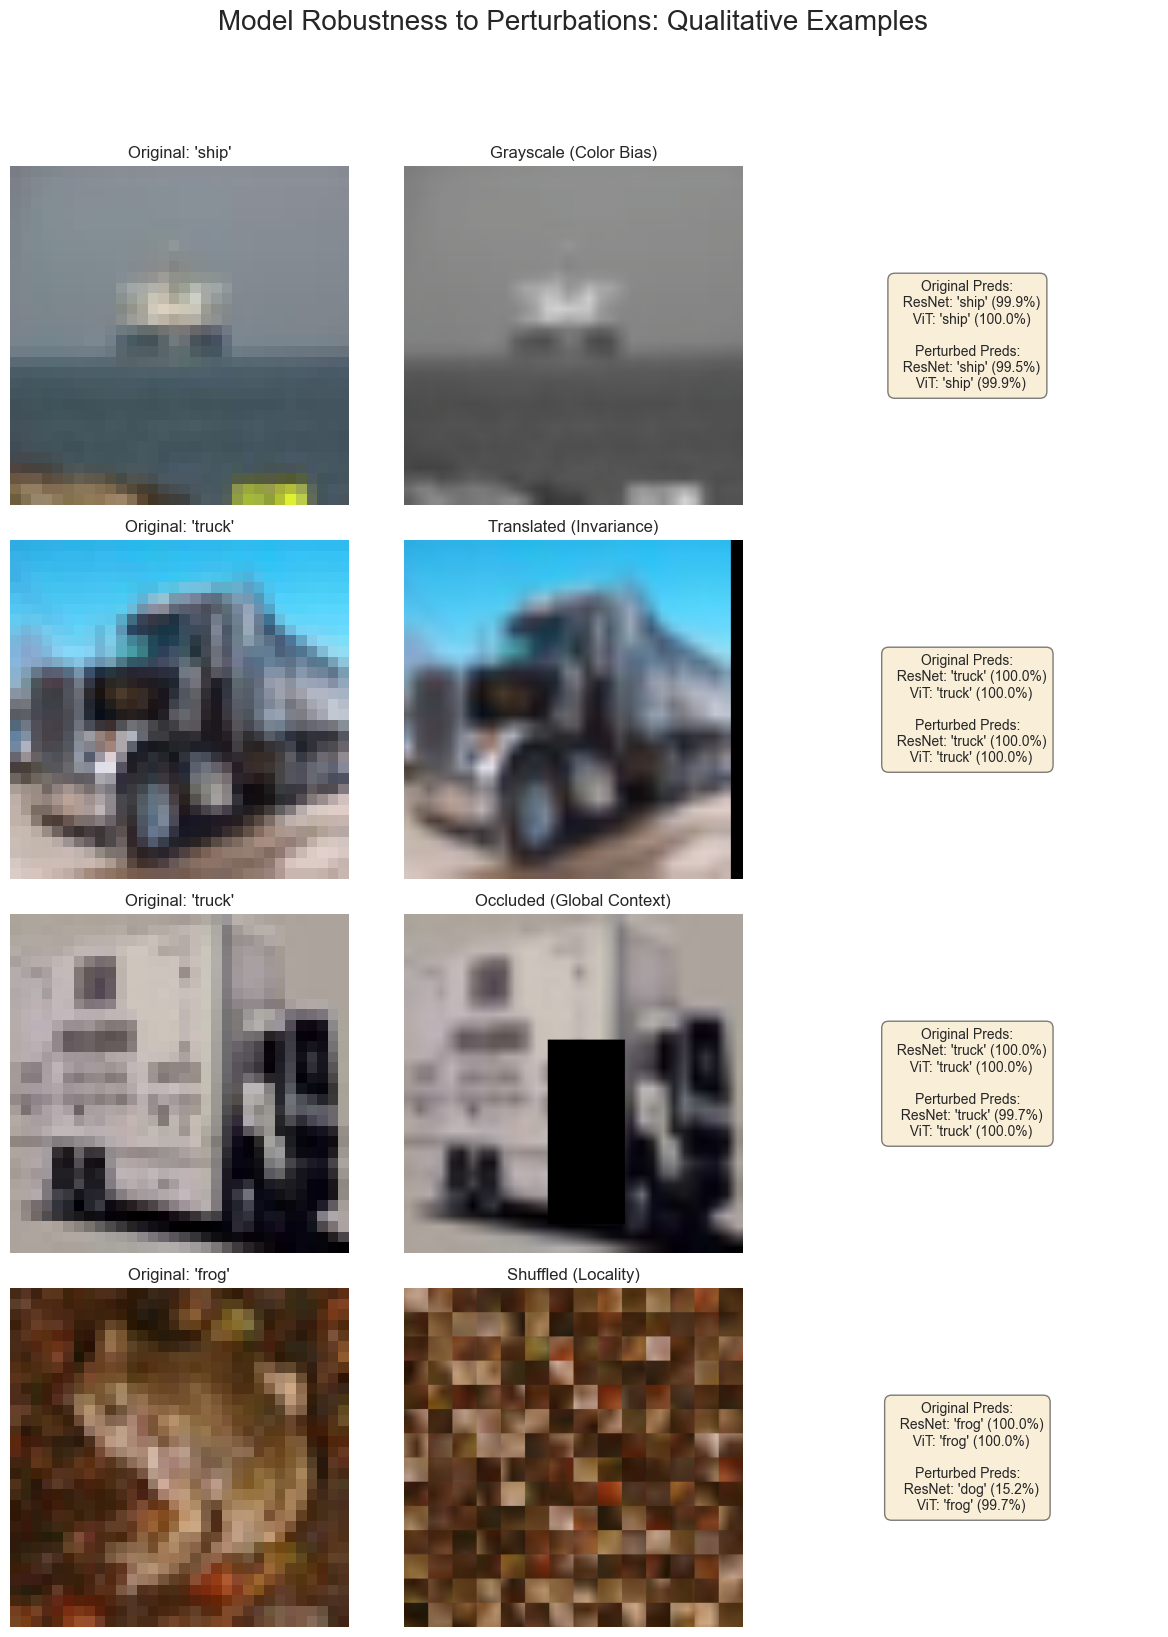

In [23]:
# =================================================================================
#      FINAL & ROBUST - VISUALIZATION: Perturbation Examples for Report
# =================================================================================

# We need the original images before they are transformed into tensors.
# We will get them directly from the dataset object.
num_examples_to_show = 4
indices_to_show = np.random.choice(len(suite.test_dataset), num_examples_to_show, replace=False)

# Get the original PIL images
# --- CORRECTED LINES ---
original_pil_images = [suite.test_dataset.data[i] for i in indices_to_show]
original_labels = [suite.test_dataset.targets[i] for i in indices_to_show]

# --- Get the transform pipelines for each perturbation ---
perturbation_transforms = {
    "Grayscale (Color Bias)": suite.create_perturbation_loaders()['Grayscale'].dataset.transform,
    "Translated (Invariance)": suite.create_perturbation_loaders()['Translated'].dataset.transform,
    "Occluded (Global Context)": suite.create_perturbation_loaders()['Occluded'].dataset.transform,
    "Shuffled (Locality)": suite.create_perturbation_loaders()['Shuffled'].dataset.transform
}

# --- Create the Figure ---
fig, axes = plt.subplots(num_examples_to_show, 3, figsize=(12, 4 * num_examples_to_show))
fig.suptitle('Model Robustness to Perturbations: Qualitative Examples', fontsize=20, y=1.02)

for i in range(num_examples_to_show):
    # --- 1. Prepare Original Image and get Predictions ---
    original_pil = Image.fromarray(original_pil_images[i])
    original_tensor = suite.transform(original_pil).unsqueeze(0).to(device)
    
    with torch.no_grad():
        resnet_orig_logits = resnet50_trained(original_tensor)
        vit_orig_logits = vit_s16_trained(original_tensor)
        resnet_orig_prob, resnet_orig_pred = torch.softmax(resnet_orig_logits, dim=1).max(1)
        vit_orig_prob, vit_orig_pred = torch.softmax(vit_orig_logits, dim=1).max(1)

    # Plot Original
    axes[i, 0].imshow(original_pil)
    axes[i, 0].set_title(f"Original: '{suite.class_names[original_labels[i]]}'")
    axes[i, 0].axis('off')

    # --- 2. Prepare Perturbed Image and get Predictions ---
    perturbation_name = list(perturbation_transforms.keys())[i]
    transform_to_apply = perturbation_transforms[perturbation_name]
    
    perturbed_tensor = transform_to_apply(original_pil).unsqueeze(0).to(device)
    
    with torch.no_grad():
        resnet_pert_logits = resnet50_trained(perturbed_tensor)
        vit_pert_logits = vit_s16_trained(perturbed_tensor)
        resnet_pert_prob, resnet_pert_pred = torch.softmax(resnet_pert_logits, dim=1).max(1)
        vit_pert_prob, vit_pert_pred = torch.softmax(vit_pert_logits, dim=1).max(1)
    
    # Plot Perturbed Version
    # We need to denormalize the tensor to show it correctly
    denorm_transform = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    perturbed_img_to_show = denorm_transform(perturbed_tensor.squeeze(0).cpu()).permute(1, 2, 0).clamp(0, 1).numpy()
    
    axes[i, 1].imshow(perturbed_img_to_show)
    axes[i, 1].set_title(perturbation_name)
    axes[i, 1].axis('off')

    # --- 3. Display Predictions as Text ---
    resnet_orig_text = f"'{suite.class_names[resnet_orig_pred.item()]}' ({resnet_orig_prob.item():.1%})"
    vit_orig_text = f"'{suite.class_names[vit_orig_pred.item()]}' ({vit_orig_prob.item():.1%})"
    resnet_pert_text = f"'{suite.class_names[resnet_pert_pred.item()]}' ({resnet_pert_prob.item():.1%})"
    vit_pert_text = f"'{suite.class_names[vit_pert_pred.item()]}' ({vit_pert_prob.item():.1%})"
    
    prediction_summary = (
        f"Original Preds:\n"
        f"  ResNet: {resnet_orig_text}\n"
        f"  ViT: {vit_orig_text}\n\n"
        f"Perturbed Preds:\n"
        f"  ResNet: {resnet_pert_text}\n"
        f"  ViT: {vit_pert_text}"
    )
    
    axes[i, 2].text(0.5, 0.5, prediction_summary, ha='center', va='center', 
                    bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5), fontsize=10)
    axes[i, 2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("perturbation_examples.png", dpi=300)
plt.show()

## Phase 3: Feature Representation Analysis

We now visualize the internal representations of the models. We extract the penultimate layer features for 500 test images from both the ResNet-50 and the ViT-S/16. By projecting these high-dimensional features into 2D with UMAP, we can qualitatively assess the structure of their learned feature spaces.

Running UMAP visualizations...


c:\Users\Haseeb\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


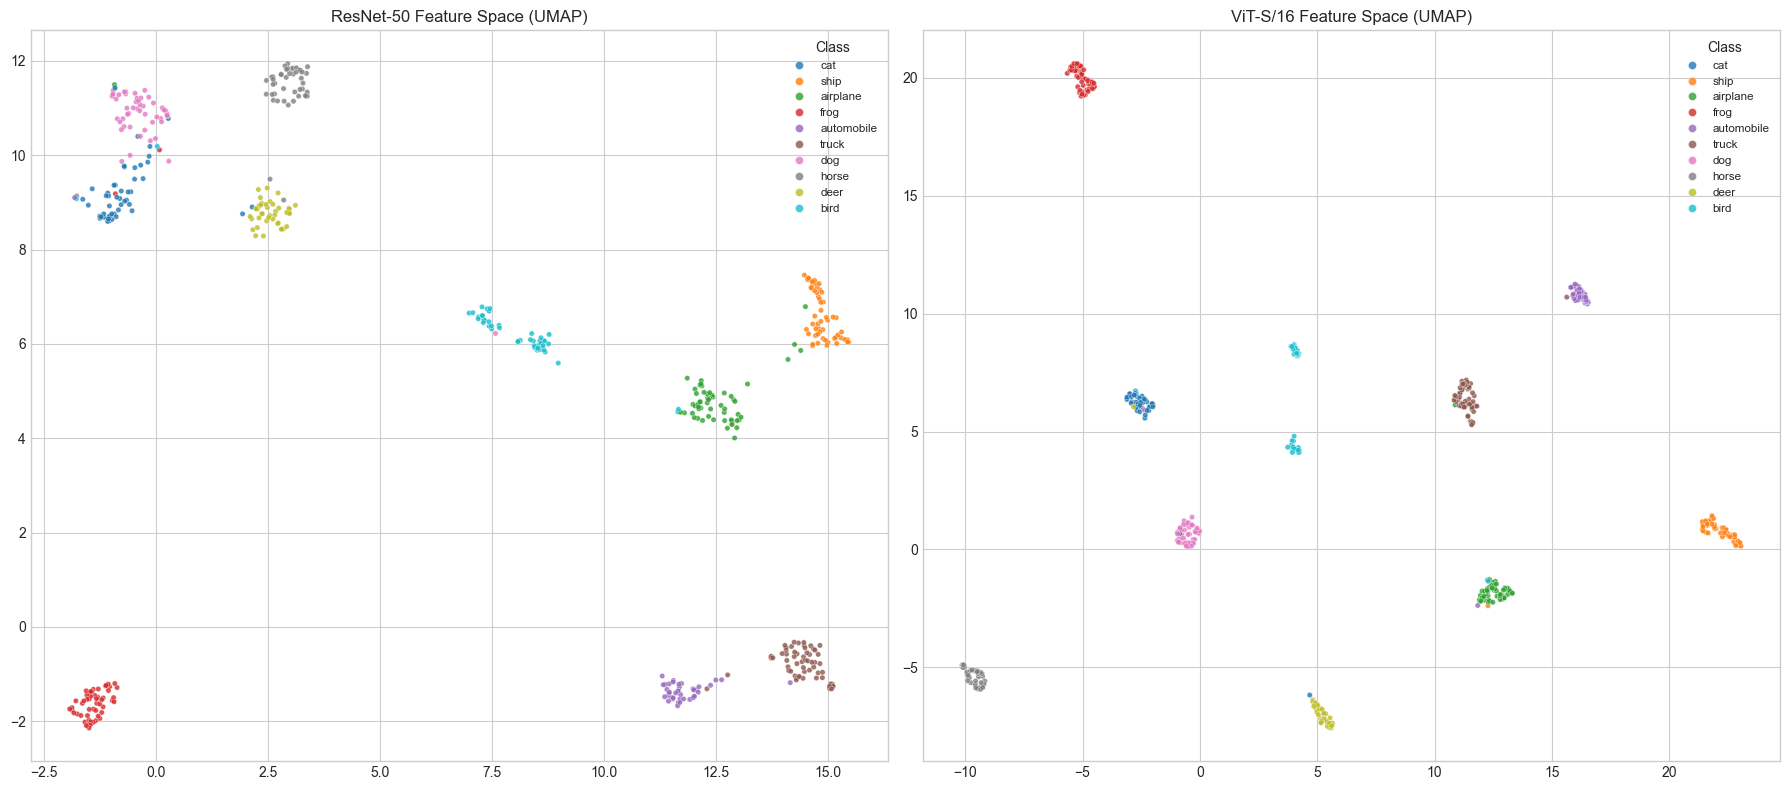

In [ ]:
def get_features(model, dataloader, num_samples=500):
    """A helper function to extract penultimate features."""
    model.eval()
    if isinstance(model, models.ResNet):
        feature_extractor = nn.Sequential(*list(model.children())[:-1])
    elif isinstance(model, timm.models.VisionTransformer):
        feature_extractor = model.forward_features
    else: raise TypeError("Unsupported model type")

    features_list, labels_list = [], []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            if i * dataloader.batch_size >= num_samples: break
            inputs = inputs.to(device)
            feats = feature_extractor(inputs)
            if feats.dim() == 4: feats = feats.squeeze(-1).squeeze(-1)
            elif 'vit' in model.default_cfg['architecture']: feats = feats[:, 0]
            features_list.append(feats.cpu()); labels_list.append(labels)
    return torch.cat(features_list).numpy(), torch.cat(labels_list).numpy()

# Extract features
resnet_features, resnet_labels = get_features(resnet50_trained, suite.test_loader)
vit_features, vit_labels = get_features(vit_s16_trained, suite.test_loader)

# Visualize with UMAP
print("Running UMAP visualizations...")
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
reducer = umap.UMAP(n_components=2, random_state=42)
class_names = suite.class_names

# ResNet Plot
resnet_2d = reducer.fit_transform(resnet_features)
sns.scatterplot(x=resnet_2d[:, 0], y=resnet_2d[:, 1], hue=[class_names[l] for l in resnet_labels], 
                palette='tab10', s=15, alpha=0.8, ax=axes[0]).set_title('ResNet-50 Feature Space (UMAP)')
axes[0].legend(title='Class', markerscale=1.5, fontsize='small')

# ViT Plot
vit_2d = reducer.fit_transform(vit_features)
sns.scatterplot(x=vit_2d[:, 0], y=vit_2d[:, 1], hue=[class_names[l] for l in vit_labels], 
                palette='tab10', s=15, alpha=0.8, ax=axes[1]).set_title('ViT-S/16 Feature Space (UMAP)')
axes[1].legend(title='Class', markerscale=1.5, fontsize='small')

plt.tight_layout(); plt.savefig("feature_space_comparison.png"); plt.show()

## Phase 4: Advanced Bias Investigations (Placeholders)

The assignment requires two more advanced experiments: a **Shape vs. Texture Bias** test (Step 4) and a **Domain Generalization Test on PACS** (Step 8). These require more complex data generation or external datasets. Below are placeholders and guidance for your group to complete them.

### Shape vs. Texture Bias (Step 4)
To implement this, you would need a style transfer library or a pre-stylized dataset. 
1. **Create Cue-Conflict Images:** For a few test images (e.g., a 'cat'), apply the texture of another class (e.g., 'truck' or 'airplane' to get a metallic texture).
2. **Evaluate Predictions:** Pass these images through both trained models. Does ResNet-50 predict 'truck' (texture bias) while ViT predicts 'cat' (shape bias)?
3. **Calculate Shape Bias Metric:** For a set of these images, calculate the `Shape Bias (%)` as defined in the assignment brief. This will be a key quantitative result for your report.

### Domain Generalization on PACS (Step 8)
1. **Download PACS:** You will need to download the PACS dataset and create DataLoaders for it.
2. **Create a Combined Training Set:** Combine the 'photo', 'art_painting', and 'cartoon' domains into a single training dataset.
3. **Fine-tune Models:** Fine-tune both ResNet-50 and ViT-S/16 from their ImageNet checkpoints on this new combined dataset.
4. **Evaluate on Sketch:** Evaluate the performance of both newly trained models on the held-out 'sketch' domain. The model with the smaller accuracy drop from its in-domain performance is the better generalizer.

In [4]:

print("Loading fine-tuned models from saved checkpoints...")

WORK_DIR = "/"
suite = ExperimentSuite(work_dir=WORK_DIR)

# Define model architectures
resnet50_trained = suite.get_model('resnet50')
vit_s16_trained = suite.get_model('vit_s_16')

# Define paths to your saved weights
resnet_path = 'resnet50_cifar10.pth'
vit_path = 'vit_s_16_cifar10.pth'

# Load the weights into the models
resnet50_trained.load_state_dict(torch.load(resnet_path, map_location=device))
vit_s16_trained.load_state_dict(torch.load(vit_path, map_location=device))

print("Models loaded and ready for evaluation.")

Loading fine-tuned models from saved checkpoints...
Loading CIFAR-10 data...
Data loading complete.
Data loading complete.
Models loaded and ready for evaluation.
Models loaded and ready for evaluation.


In [16]:
# =================================================================================
#      FINAL & ROBUST - TASK 1, STEP 4 (Including Non-Conflict & Pro Plotting)
# =================================================================================
from torch.utils.data import Dataset
from PIL import Image
import re

# --- 1. Define the path to your downloaded dataset ---
CUE_CONFLICT_DIR = "./rgeirhos texture-vs-shape master stimuli-style-transfer-preprocessed-512"

class CompleteCueConflictDataset(Dataset):
    """
    A robust custom dataset that loads the official cue-conflict images,
    and correctly filters for samples relevant to the 10 CIFAR-10 classes.
    THIS VERSION INCLUDES non-conflict images (e.g., cat-cat).
    """
    def __init__(self, root_dir, cifar_class_names, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.cifar_class_set = set(cifar_class_names)
        self.class_to_idx = {name: i for i, name in enumerate(cifar_class_names)}
        self.samples = []
        
        print(f"Parsing official cue-conflict dataset from: {root_dir}")
        if not os.path.isdir(root_dir):
            raise FileNotFoundError(f"Directory not found: '{root_dir}'. Please ensure the path is correct.")

        for shape_label in os.listdir(root_dir):
            if shape_label in self.cifar_class_set:
                class_dir = os.path.join(root_dir, shape_label)
                if not os.path.isdir(class_dir): continue
                
                for filename in os.listdir(class_dir):
                    if filename.endswith('.png'):
                        try:
                            texture_label = re.split(r'\d+', filename.split('-')[1])[0]
                            # The only filter is that both labels must be in CIFAR-10
                            if texture_label in self.cifar_class_set:
                                img_path = os.path.join(class_dir, filename)
                                self.samples.append((img_path, shape_label, texture_label))
                        except IndexError:
                            continue
        print(f"Found {len(self.samples)} valid images (including non-conflict) for CIFAR-10 classes.")

    def __len__(self): return len(self.samples)
        
    def __getitem__(self, idx):
        img_path, shape_label_str, texture_label_str = self.samples[idx]
        shape_label_idx = self.class_to_idx[shape_label_str]
        texture_label_idx = self.class_to_idx[texture_label_str]
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, shape_label_idx, texture_label_idx

# --- 2. Create the DataLoader ---
cue_conflict_dataset = CompleteCueConflictDataset(CUE_CONFLICT_DIR, suite.class_names, transform=suite.transform)
cue_conflict_loader = DataLoader(cue_conflict_dataset, batch_size=32, shuffle=False, num_workers=0)

# --- 3. Run Evaluation Loop ---
# This part of your code is already robust and correct.
print("\n--- Evaluating models on the complete official dataset ---")
results_list = []
for model_name, model in [('ResNet-50', resnet50_trained), ('ViT-S/16', vit_s16_trained)]:
    model.eval()
    for images, shape_indices, texture_indices in tqdm(cue_conflict_loader, desc=f"Evaluating {model_name}"):
        images = images.to(device)
        with torch.no_grad():
            logits = model(images)
            probs = torch.softmax(logits, dim=1)
            confidences, pred_indices = torch.max(probs, 1)
        for i in range(len(images)):
            results_list.append({
                "Model": model_name, "Shape_Label": suite.class_names[shape_indices[i].item()],
                "Texture_Label": suite.class_names[texture_indices[i].item()],
                "Prediction": suite.class_names[pred_indices[i].item()], "Confidence": confidences[i].item()
            })

# --- 4. Calculate and Display the Shape Bias Metric ---
bias_df = pd.DataFrame(results_list)
# The calculate_shape_bias function is also correct and handles non-conflict cases naturally.
resnet_bias, resnet_shape, resnet_texture = calculate_shape_bias(bias_df, 'ResNet-50')
vit_bias, vit_shape, vit_texture = calculate_shape_bias(bias_df, 'ViT-S/16')

print("\n" + "="*50); print("     SHAPE VS. TEXTURE BIAS RESULTS (Official Dataset)"); print("="*50)
print(f"Based on {len(cue_conflict_dataset)} images.\n")
print(f"ResNet-50:\n  - Shape-based predictions: {resnet_shape}\n  - Texture-based predictions: {resnet_texture}\n  - Shape Bias: {resnet_bias:.2f}%")
print("-" * 30)
print(f"ViT-S/16:\n  - Shape-based predictions: {vit_shape}\n  - Texture-based predictions: {vit_texture}\n  - Shape Bias: {vit_bias:.2f}%")
print("="*50)

Parsing official cue-conflict dataset from: ./rgeirhos texture-vs-shape master stimuli-style-transfer-preprocessed-512
Found 125 valid images (including non-conflict) for CIFAR-10 classes.

--- Evaluating models on the complete official dataset ---


Evaluating ViT-S/16: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


     SHAPE VS. TEXTURE BIAS RESULTS (Official Dataset)
Based on 125 images.

ResNet-50:
  - Shape-based predictions: 46
  - Texture-based predictions: 36
  - Shape Bias: 56.10%
------------------------------
ViT-S/16:
  - Shape-based predictions: 53
  - Texture-based predictions: 54
  - Shape Bias: 49.53%


Found 4 examples where models disagreed to visualize.


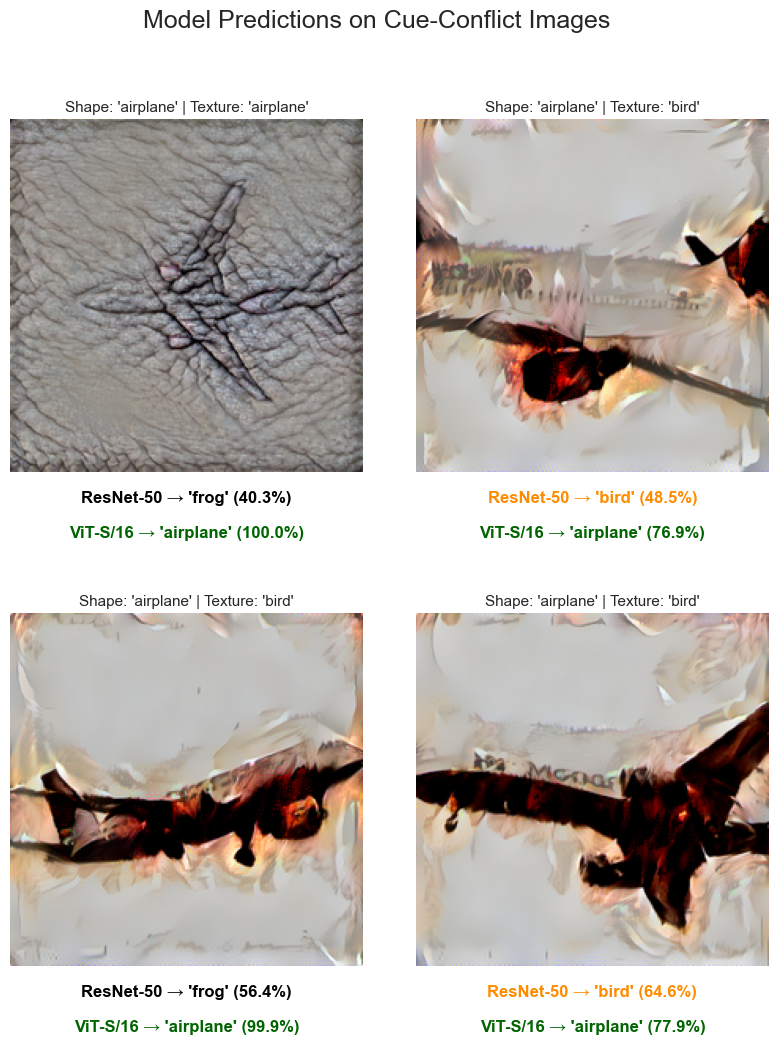

In [19]:
# =================================================================================
#      FINAL, ROBUST, AND CORRECTED VISUALIZATION (FIXES TEXT ERROR)
# =================================================================================

# --- 1. Robustly Find Examples for Visualization ---
# (This part is correct and remains the same)
bias_df['image_id'] = bias_df.groupby(['Model', 'Shape_Label', 'Texture_Label']).cumcount()
pivot_df = bias_df.pivot_table(
    index=['Shape_Label', 'Texture_Label', 'image_id'],
    columns='Model',
    values=['Prediction', 'Confidence'],
    aggfunc='first'
)
pivot_df.columns = [f'{col[0]}_{col[1]}' for col in pivot_df.columns]
pivot_df = pivot_df.reset_index()

disagreement_df = pivot_df[pivot_df['Prediction_ResNet-50'] != pivot_df['Prediction_ViT-S/16']].head(4)
print(f"Found {len(disagreement_df)} examples where models disagreed to visualize.")
if len(disagreement_df) == 0:
    print("No disagreements found. Plotting first 4 examples instead.")
    disagreement_df = pivot_df.head(4)

# --- 2. Create the High-Quality 2x2 Subplot Figure ---
num_examples = len(disagreement_df)
if num_examples > 0:
    fig, axes = plt.subplots(2, 2, figsize=(10, 11))
    fig.suptitle("Model Predictions on Cue-Conflict Images", fontsize=18, y=0.98)
    axes = axes.flatten()

    for i, (_, row) in enumerate(disagreement_df.iterrows()):
        ax = axes[i]
        shape_label = row['Shape_Label']
        texture_label = row['Texture_Label']
        
        # Find the corresponding image file
        img_filename = None
        folder_path = os.path.join(CUE_CONFLICT_DIR, shape_label)
        matching_files = sorted([f for f in os.listdir(folder_path) if texture_label in f])
        if row['image_id'] < len(matching_files):
            img_filename = os.path.join(folder_path, matching_files[row['image_id']])

        # Plot the image
        if img_filename: ax.imshow(Image.open(img_filename))
        
        ax.set_title(f"Shape: '{shape_label}' | Texture: '{texture_label}'", fontsize=11)
        ax.axis('off')

        # --- CORRECTED PREDICTION TEXT PLOTTING ---
        resnet_pred = row['Prediction_ResNet-50']
        resnet_conf = row['Confidence_ResNet-50']
        vit_pred = row['Prediction_ViT-S/16']
        vit_conf = row['Confidence_ViT-S/16']
        
        # Color-coding: Green for shape-match, Orange for texture-match, Black for other
        resnet_color = 'darkgreen' if resnet_pred == shape_label else ('darkorange' if resnet_pred == texture_label else 'black')
        vit_color = 'darkgreen' if vit_pred == shape_label else ('darkorange' if vit_pred == texture_label else 'black')
        
        # Create the text strings
        resnet_text = f"ResNet-50 → '{resnet_pred}' ({resnet_conf:.1%})"
        vit_text = f"ViT-S/16 → '{vit_pred}' ({vit_conf:.1%})"
        
        # Add the text below the plot with the correct colors
        ax.text(0.5, -0.05, resnet_text, ha='center', va='top', transform=ax.transAxes, fontsize=12, color=resnet_color, weight='bold')
        ax.text(0.5, -0.15, vit_text, ha='center', va='top', transform=ax.transAxes, fontsize=12, color=vit_color, weight='bold')

    # Hide any unused subplots
    for j in range(num_examples, len(axes)):
        axes[j].axis('off')

    plt.subplots_adjust(hspace=0.4, wspace=0.1)
    plt.savefig("cue_conflict_figure_final.png", dpi=300, bbox_inches='tight')
    plt.show()

In [8]:
# Step 8: Domain Generalization on PACS
class PacsDataset(Dataset):
    def __init__(self, root_dir, domains, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.domains = domains
        
        for domain in self.domains:
            domain_path = os.path.join(root_dir, domain)
            for class_name in os.listdir(domain_path):
                class_path = os.path.join(domain_path, class_name)
                if os.path.isdir(class_path):
                    for img_name in os.listdir(class_path):
                        self.image_paths.append(os.path.join(class_path, img_name))
                        self.labels.append(class_name)
                        
        self.class_to_idx = {cls: i for i, cls in enumerate(sorted(list(set(self.labels))))}
        self.idx_to_class = {i: cls for cls, i in self.class_to_idx.items()}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[self.labels[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

# Step B: Create the datasets and loaders
pacs_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_domains = ['photo', 'art_painting', 'cartoon']
test_domain = ['sketch']

pacs_train_dataset = PacsDataset(root_dir=r'D:\Haseeb\SPROJ\PACS ViT\pacs_data\pacs_data', domains=train_domains, transform=pacs_transform)
pacs_test_dataset = PacsDataset(root_dir=r'D:\Haseeb\SPROJ\PACS ViT\pacs_data\pacs_data', domains=test_domain, transform=pacs_transform)

pacs_train_loader = DataLoader(pacs_train_dataset, batch_size=32, shuffle=True)
pacs_test_loader = DataLoader(pacs_test_dataset, batch_size=32, shuffle=False)
print(f"PACS loaded: {len(pacs_train_dataset)} training images, {len(pacs_test_dataset)} test images.")

# Step C: Fine-tune models on PACS
# Create new instances of the models to train on PACS (7 classes)
resnet_pacs = suite.get_model('resnet50', num_classes=7)
vit_pacs = suite.get_model('vit_s_16', num_classes=7)

suite.train_loader = pacs_train_loader
suite.test_loader = pacs_test_loader

print("\n--- Training ResNet-50 on PACS ---")
resnet_pacs_trained, _ = suite.train_model(resnet_pacs, 'resnet50_pacs', num_epochs=5)

print("\n--- Training ViT-S/16 on PACS ---")
vit_pacs_trained, _ = suite.train_model(vit_pacs, 'vit_s16_pacs', num_epochs=5)

# Step D: Final evaluation on the sketch domain
print("\n--- Final PACS Domain Generalization Results ---")
resnet_pacs_acc, _, _ = suite.evaluate_model(resnet_pacs_trained, pacs_test_loader)
vit_pacs_acc, _, _ = suite.evaluate_model(vit_pacs_trained, pacs_test_loader)

print(f"ResNet-50 accuracy on Sketch domain: {resnet_pacs_acc*100:.2f}%")
print(f"ViT-S/16 accuracy on Sketch domain: {vit_pacs_acc*100:.2f}%")

PACS loaded: 6062 training images, 3929 test images.

--- Training ResNet-50 on PACS ---
--- Training resnet50_pacs ---


Train Epoch 1/5:   0%|          | 0/190 [00:00<?, ?it/s]

Train Loss: 0.9783 Acc: 0.7334


Val Epoch 1/5:   0%|          | 0/123 [00:00<?, ?it/s]

Val Loss: 1.3247 Acc: 0.5353
New best model saved to D:\Haseeb\ATML assignments\resnet50_pacs_cifar10.pth with accuracy: 0.5353


Train Epoch 2/5:   0%|          | 0/190 [00:00<?, ?it/s]

Train Loss: 0.2418 Acc: 0.9337


Val Epoch 2/5:   0%|          | 0/123 [00:00<?, ?it/s]

Val Loss: 1.1643 Acc: 0.5737
New best model saved to D:\Haseeb\ATML assignments\resnet50_pacs_cifar10.pth with accuracy: 0.5737


Train Epoch 3/5:   0%|          | 0/190 [00:00<?, ?it/s]

Train Loss: 0.1329 Acc: 0.9624


Val Epoch 3/5:   0%|          | 0/123 [00:00<?, ?it/s]

Val Loss: 1.0912 Acc: 0.6009
New best model saved to D:\Haseeb\ATML assignments\resnet50_pacs_cifar10.pth with accuracy: 0.6009


Train Epoch 4/5:   0%|          | 0/190 [00:00<?, ?it/s]

Train Loss: 0.0767 Acc: 0.9797


Val Epoch 4/5:   0%|          | 0/123 [00:00<?, ?it/s]

Val Loss: 1.1687 Acc: 0.6002


Train Epoch 5/5:   0%|          | 0/190 [00:00<?, ?it/s]

Train Loss: 0.0533 Acc: 0.9880


Val Epoch 5/5:   0%|          | 0/123 [00:00<?, ?it/s]

Val Loss: 1.0288 Acc: 0.6505
New best model saved to D:\Haseeb\ATML assignments\resnet50_pacs_cifar10.pth with accuracy: 0.6505
Training complete. Best val Acc: 0.6505

--- Training ViT-S/16 on PACS ---
--- Training vit_s16_pacs ---


Train Epoch 1/5:   0%|          | 0/190 [00:00<?, ?it/s]

Train Loss: 0.2721 Acc: 0.9058


Val Epoch 1/5:   0%|          | 0/123 [00:00<?, ?it/s]

Val Loss: 2.0207 Acc: 0.2879
New best model saved to D:\Haseeb\ATML assignments\vit_s16_pacs_cifar10.pth with accuracy: 0.2879


Train Epoch 2/5:   0%|          | 0/190 [00:00<?, ?it/s]

Train Loss: 0.0329 Acc: 0.9888


Val Epoch 2/5:   0%|          | 0/123 [00:00<?, ?it/s]

Val Loss: 1.7577 Acc: 0.4271
New best model saved to D:\Haseeb\ATML assignments\vit_s16_pacs_cifar10.pth with accuracy: 0.4271


Train Epoch 3/5:   0%|          | 0/190 [00:00<?, ?it/s]

Train Loss: 0.0040 Acc: 0.9998


Val Epoch 3/5:   0%|          | 0/123 [00:00<?, ?it/s]

Val Loss: 1.8820 Acc: 0.4039


Train Epoch 4/5:   0%|          | 0/190 [00:00<?, ?it/s]

Train Loss: 0.0012 Acc: 1.0000


Val Epoch 4/5:   0%|          | 0/123 [00:00<?, ?it/s]

Val Loss: 1.9155 Acc: 0.4100


Train Epoch 5/5:   0%|          | 0/190 [00:00<?, ?it/s]

Train Loss: 0.0008 Acc: 1.0000


Val Epoch 5/5:   0%|          | 0/123 [00:00<?, ?it/s]

Val Loss: 2.0061 Acc: 0.4037
Training complete. Best val Acc: 0.4271

--- Final PACS Domain Generalization Results ---


Evaluating:   0%|          | 0/123 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/123 [00:00<?, ?it/s]

ResNet-50 accuracy on Sketch domain: 65.05%
ViT-S/16 accuracy on Sketch domain: 42.71%
